# Introduction to Data Science
## Hands-on demonstration - Decision Tree

We are going to need a lot of Python packages, so let's start by importing all of them.

In [1]:
# Import the libraries we will be using
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

We are also going to do a lot of repetitive stuff, so let's predefine some useful functions.

Note that we need to install graphviz package. Follow the instruction below to install it.
http://www.graphviz.org/Download_macos.php

In [2]:
# A function that gives a visual representation of the decision tree
def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    # Export our decision tree to graphviz format
    #dot_file = tree.export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    
    # Call graphviz to make an image file from our decision tree
    #os.system("dot -Tpng images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')

# A function to plot the data
def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) - 1, max(data[v1]) + 1])
    plt.ylim([min(data[v2]) - .05, max(data[v2]) + .05])
    


We also need some data, so let's create a dataset consisting of 500 people.

In [3]:
# Set the randomness
np.random.seed(36)

# Number of users
n_users = 500

# Relationships
variable_names = ["age", "humor", "number_pets"]
variables_keep = ["number_pets", "humor"]
target_name = "success"

# Generate data
predictors, target = datasets.make_classification(n_features=3, n_redundant=0, 
                                                  n_informative=2, n_clusters_per_class=2,
                                                  n_samples=n_users)
data = pd.DataFrame(predictors, columns=variable_names)
data['age'] = data['age'] * 10 + 50
data['humor'] = data['humor'] * 10 + 50
data['number_pets'] = (data['number_pets'] + 6)/2
data[target_name] = target

X = data[[variables_keep[0], variables_keep[1]]]
Y = data[target_name]

### Useful features
Let's take a look at one of our features -- `"number_pets"`. Is this feature useful? Let's plot the possible values of `"number_pets"` and color code our target variable, which is, in this case, `"success"`.

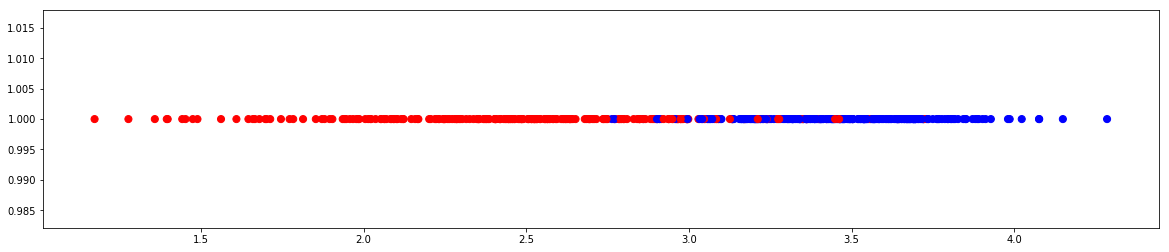

In [4]:
# Make the plot long
plt.rcParams['figure.figsize'] = [20.0, 4.0]
color = ["red" if x == 0 else "blue" for x in data["success"]]
plt.scatter(X['number_pets'], [1] * n_users, c=color, s=50)

Is `"number_pets"` actually useful? Let's quantify it.

**Entropy** ($H$) and **information gain** ($IG$) are crucial in determining which features are the most informative. Given the data, it is fairly straight forward to calculate both of these.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="images/dsfb_0304.png" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="images/dsfb_0305.png" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

In [5]:
def entropy(target):
    # Get the number of users
    n = len(target)
    # Count how frequently each unique value occurs
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    # If the split is perfect, return 0
    if len(counts) <= 1 or 0 in counts:
        return entropy
    # Otherwise, for each possible value, update entropy
    for count in counts:
        entropy += math.log(count/n, len(counts)) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

Now that we have a way of calculating $H$ and $IG$, let's pick a threshold, split `"number_pets"`, and calculate $IG$.

In [6]:
threshold = 3.2
print "IG = %.4f with a thresholding of %.2f." % (information_gain(X['number_pets'], threshold, np.array(Y)), threshold)

IG = 0.4719 with a thresholding of 3.20.


To be more precise, we can iterate through all values and find the best split.

In [7]:
def best_threshold():
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X['number_pets']:
        ig = information_gain(X['number_pets'], threshold, np.array(Y))
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG = %.3f and it occured by splitting on %.4f." % (maximum_ig, maximum_threshold)

print best_threshold()

The maximum IG = 0.603 and it occured by splitting on 3.0326.


Let's see how we can do this with just sklearn!

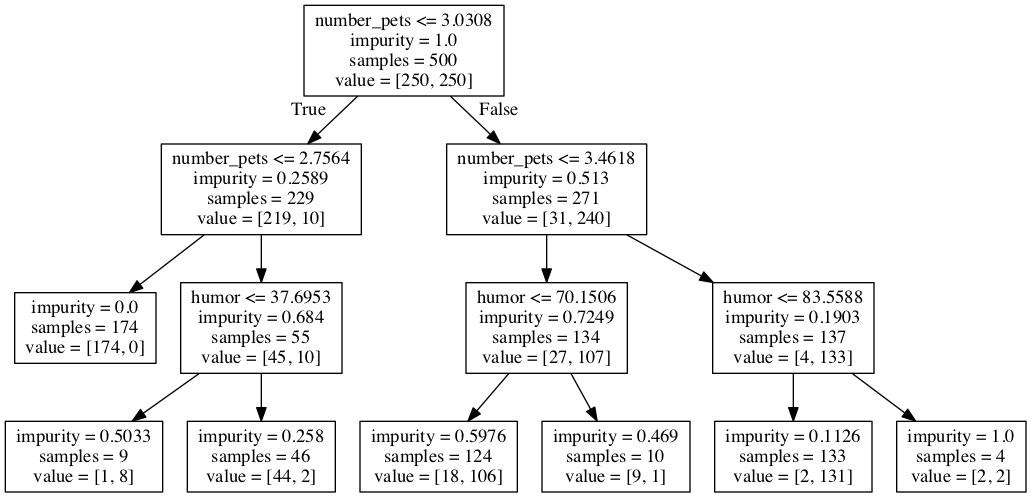

In [8]:
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")
decision_tree.fit(X, Y)
Decision_Tree_Image(decision_tree, X.columns)

Let's look at another one of our features, `"humor"`, and see how it relates to `"number_pets"`.

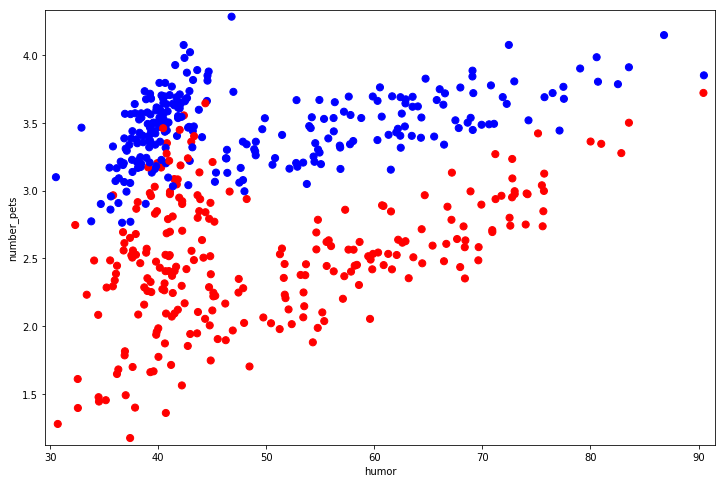

In [9]:
Plot_Data(data, "humor", "number_pets", "success")

If we use this as our decision tree, how accurate is it?

In [10]:
print "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(X), Y))

Accuracy = 0.948


Let's add one more level to our decision tree.

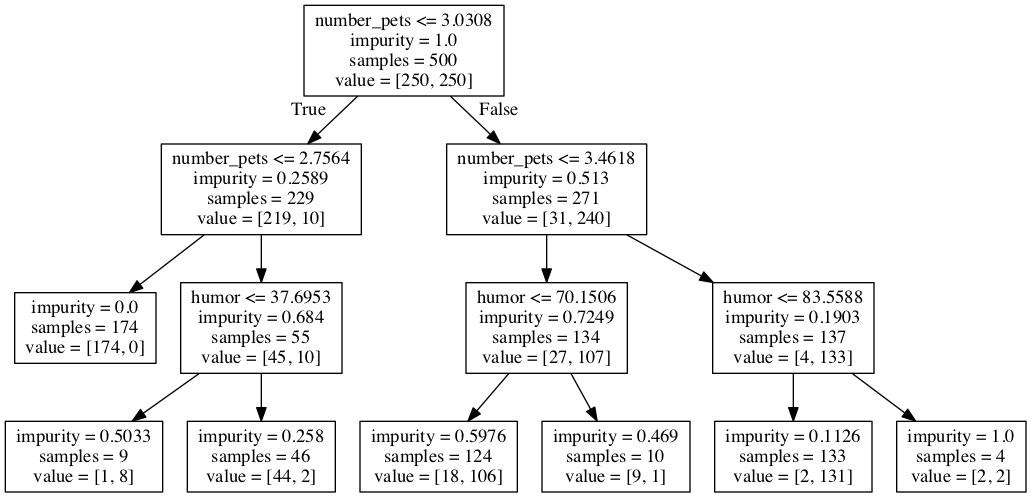

In [11]:
decision_tree = DecisionTreeClassifier(max_depth=2, criterion="entropy")
decision_tree.fit(X, Y)
Decision_Tree_Image(decision_tree, X.columns)

In [12]:
print "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(X), Y))

Accuracy = 0.918


## Your turn
Not much of a change? Can you see why? Try experimenting with different values of `max_depth` and find which one is the most accurate. Is there a point where the tree stops growing?

In [ ]:
# Your code here!